In [20]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
import ruptures as rpt


import json
import os
from datetime import datetime

from utils import running_mean

import seaborn as sns
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

chosen_cmap = 'viridis'
num_colors = 15
colors = [plt.get_cmap(chosen_cmap)(i / (num_colors - 1)) for i in range(num_colors)]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

IMAGEDIR = "./images/scratch/"
DRYRUN = True
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9

if not DRYRUN:
    os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


_to_array = lambda x: np.array(x)
COLUMN_TRANSFORM = {
    "component_potential_grad_norm": _to_array,
    "corrected_total_matrix": _to_array,
    "total_matrix": _to_array,
    "potential_matrix": _to_array,
}


def parse_sgd_logs(logs):
    print("Parsing SGD logs...")
    eval_names = logs["eval_list"]
    other_cols = None
    data = []
    for checkpoint in logs["checkpoint_logs"]:
        keys = sorted(checkpoint.keys())
        keys.remove("evals")
        if other_cols is None:
            other_cols = keys
        else:
            assert keys == other_cols
        checkpoint_data = [
            checkpoint[key] for key in keys
        ] + checkpoint["evals"]
        data.append(checkpoint_data)
    columns = other_cols + eval_names
    df = pd.DataFrame(data, columns=columns)
    print(f"Data shape: {df.shape}")
    # apply COLUMN_TRANSFORM
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df

def parse_gd_logs(logs):
    print("Parsing GD logs...")
    eval_names = logs["eval_list"]
    other_cols = None
    data = []
    for checkpoint in logs["checkpoint_logs"]:
        keys = sorted(checkpoint.keys())
        keys.remove("evals")
        if "total_matrix" in keys:
            keys.remove("total_matrix")
        if other_cols is None:
            other_cols = keys
        else:
            assert keys == other_cols, f"Keys: {keys}, other_cols: {other_cols}"
        checkpoint_data = [
            checkpoint[key] for key in keys
        ] + checkpoint["evals"]
        data.append(checkpoint_data)
    columns = other_cols + eval_names
    df = pd.DataFrame(data, columns=columns)
    print(f"Data shape: {df.shape}")
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df



def parse_individual_stagewise_gd_logs(logs):
    eval_names = logs["eval_lists"]
    eval_names = [name for name in eval_names if not name.startswith("stage_llc")]
    num_stages = logs["num_stages"]
    
    if num_stages != len(logs["stage_logs"]):
        print("Warning: num_stages does not match the number of stage logs.")
    other_cols = None
    data = []
    accumuated_time = 0
    other_info = {}
    for stage in range(num_stages):
        llc_key = f"stage_llc_{stage}"
        other_info[stage] = {}
        if llc_key in logs:
            other_info[stage]["llc"] = logs[llc_key]
        llc_potential_key = f"stage_llc_known_potential_{stage}"
        if llc_potential_key in logs:
            other_info[stage]["llc_potential"] = logs[llc_potential_key]
        

    for stage, stage_logs in enumerate(logs["stage_logs"]):
        for checkpoint in stage_logs:
            keys = sorted(checkpoint.keys())
            keys.remove("evals")
            if "total_matrix" in keys:
                keys.remove("total_matrix")
        
            if other_cols is None:
                other_cols = keys
            else:
                assert keys == other_cols, f"Keys: {keys}, other_cols: {other_cols}"
            checkpoint_data = (
                [checkpoint[key] for key in keys] 
                + checkpoint["evals"] 
                + [stage, num_stages, checkpoint["t"] + accumuated_time]
            )
            data.append(checkpoint_data)
        accumuated_time += stage_logs[-1]["t"]
    columns = other_cols + eval_names + ["stage", "num_stages", "total_time"]
    df = pd.DataFrame(data, columns=columns)
    print(f"Data shape: {df.shape}")
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df, other_info

def parse_stagewise_gd_logs(logs):
    print("Parsing Stagewise GD logs...")
    results = {}
    for potential_type, potential_logs in logs.items():
        print(f"Parsing GD logs for stagewise potential type: {potential_type}")
        df, other_info = parse_individual_stagewise_gd_logs(potential_logs)
        results[potential_type] = {
            "df": df,
            "other_info": other_info,
        }
        
    return results


# Query Directory or Database and Parse Data

In [15]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['test_dln_stagewise_learning']
collection = db['runs']

EXPT_NAME = "test_run"

query = {
    # "config.expt_name": EXPT_NAME, 
    # "status": "COMPLETED", 
    # "_id": 24 # init origin
    # "_id": 29 # init away from origin 
    "_id": 46
}
expt_info = collection.find_one(query)["info"]
expt_config = collection.find_one(query)["config"]
expt_properties = expt_info["expt_properties"]

df_sgd = parse_sgd_logs(expt_info["sgd_logs"])
df_gd = parse_gd_logs(expt_info["gd_logs"])
stagewise_dfs = parse_stagewise_gd_logs(expt_info["stagewise_gd_logs"])


Parsing SGD logs...
Data shape: (556, 19)
Parsing GD logs...
Data shape: (371, 14)
Parsing Stagewise GD logs...
Parsing GD logs for stagewise potential type: block
Data shape: (489, 11)
Parsing GD logs for stagewise potential type: diag
Data shape: (153, 11)
Parsing GD logs for stagewise potential type: col
Data shape: (566, 11)
Parsing GD logs for stagewise potential type: row
Data shape: (574, 11)
Parsing GD logs for stagewise potential type: corner
Data shape: (487, 11)
Parsing GD logs for stagewise potential type: offdiag_inclusive
Data shape: (24514, 12)
Parsing GD logs for stagewise potential type: offdiag_exclusive
Data shape: (3871, 12)
Parsing GD logs for stagewise potential type: row_col
Data shape: (126, 11)


In [120]:
import gzip
# _ID = 24 # band, dim=12
# _ID = 25 # band, dim=18
# _ID = 27 # band, dim=18, num_chains=3
_ID = 31 # band, dim=21, num_chains=5, num_steps=1000, epsilon=2e-5, num_steps=300k
# _ID = 32 # band, dim=21, num_chains=5, num_steps=800, epsilon=5e-5, num_steps=500k
DATA_DIR = f"./outputs/test/{_ID}/"

# DATA_DIR = (
#     "./spartan_outputs/"
#     "dln_stagewise_learning/prod/dln_small_width8-15_layers1-5_in8_out8_n100000_bs512_lr1e-05_nstep500000_optimsgd_202409181118/11/"
# )


def _read_json_file(filepath):
    assert filepath.endswith(".json") or filepath.endswith(".json.gz")
    if filepath.endswith(".json"):
        with open(filepath, "r") as f:
            data = json.load(f)
    else:
        with gzip.open(filepath, "rb") as f:
            data = json.load(f)
    return data

def extract_directory(dir_path):
    filelist = os.listdir(dir_path)
    print(f"Extracting directory: {dir_path}. Found {len(filelist)} files: \n   {filelist}")
    config_filename = "config.json" if "config.json" in filelist else "config.json.gz"
    info_filename = "info.json" if "info.json" in filelist else "info.json.gz"
    expt_config = _read_json_file(os.path.join(dir_path, config_filename))
    expt_info = _read_json_file(os.path.join(dir_path, info_filename))
    expt_properties = expt_info["expt_properties"]

    df_sgd = parse_sgd_logs(expt_info["sgd_logs"])
    df_gd = parse_gd_logs(expt_info["gd_logs"])
    stagewise_dfs = parse_stagewise_gd_logs(expt_info["stagewise_gd_logs"])
    return expt_config, expt_info, expt_properties, df_sgd, df_gd, stagewise_dfs

expt_config, expt_info, expt_properties, df_sgd, df_gd, stagewise_dfs = extract_directory(DATA_DIR)


Extracting directory: ./outputs/test/31/. Found 5 files: 
   ['metrics.json', 'config.json', 'info.json', 'run.json', 'cout.txt']
Parsing SGD logs...
Data shape: (750, 15)
Parsing GD logs...
Data shape: (751, 9)
Parsing Stagewise GD logs...
Parsing GD logs for stagewise potential type: behavioural
Data shape: (15771, 27)
Parsing GD logs for stagewise potential type: block
Data shape: (5426, 27)
Parsing GD logs for stagewise potential type: diag
Data shape: (749, 27)
Parsing GD logs for stagewise potential type: row_col
Data shape: (5653, 27)


In [121]:
do_llc_estimation = expt_config["do_llc_estimation"]
input_dim = expt_config["model_config"]["input_dim"]
output_dim = expt_config["model_config"]["output_dim"]
teacher_matrix = np.array(expt_properties["teacher_matrix"])
input_correlation_matrix = np.array(expt_properties["input_correlation_matrix"])
input_output_correlation_matrix = np.array(expt_properties["input_output_cross_correlation_matrix"])
U, S, V, Vhat, ChangeOfBasis = [
    np.array(expt_properties["svd_matrices"][key]) for key in [
        "U", "S", "V", "Vhat", "ChangeOfBasis"
    ]
]
stage_potential_types = list(stagewise_dfs.keys())
eval_mode = expt_config["eval_mode"]
num_modes = min(input_dim, output_dim)

In [122]:
expt_config

{'burn_in_prop': 0.9,
 'data_config': {'feature_map': None,
  'idcorr': True,
  'input_variance_range': [1.0, 10.0],
  'num_training_data': 10000,
  'output_noise_std': 0.1,
  'teacher_matrix': {'config_vals': '[2.0,5.0,2]', 'type': 'band'}},
 'do_llc_estimation': True,
 'do_plotting': False,
 'eval_mode': 'minimal',
 'expt_name': 'test_run',
 'gd_training_config': {'early_stopping_epsilon': 0.0005,
  'learning_rate': 1.25e-05,
  'min_num_steps': 2000,
  'num_steps': 300000},
 'itemp': None,
 'log_full_checkpoint_param': False,
 'logging_period': 400,
 'loss_trace_minibatch': True,
 'model_config': {'hidden_layer_widths': [21, 21],
  'init_origin': True,
  'initialisation_exponent': 2,
  'input_dim': 21,
  'output_dim': 21},
 'seed': 0,
 'sgld_config': {'batch_size': 512,
  'epsilon': 2e-08,
  'gamma': 1.0,
  'num_chains': 5,
  'num_steps': 1000},
 'spectral_resolution': None,
 'training_config': {'batch_size': 128,
  'early_stopping_loss_threshold': 0.001,
  'learning_rate': 5e-05,
  

# SGD Training

(750, 15) 100
(750, 15) 135
(750, 15) 210
(750, 15) 250
(750, 15) 400
(750, 15) 525
(750, 15) 600
(750, 15) 750


Text(0.5, 0.98, "burn_in_prop: 0.9, data_config: {'feature_map': None, 'idcorr': True, 'input_variance_range': [1.0, 10.0], 'num_training_data': 10000, 'output_noise_std': 0.1, 'teacher_matrix': {'config_vals': '[2.0,5.0,2]', 'type': 'band'}}, \ndo_llc_estimation: True, do_plotting: False, eval_mode: minimal, expt_name: test_run, \ngd_training_config: {'early_stopping_epsilon': 0.0005, 'learning_rate': 1.25e-05, 'min_num_steps': 2000, 'num_steps': 300000}, \nitemp: None, log_full_checkpoint_param: False, logging_period: 400, loss_trace_minibatch: True, \nmodel_config: {'hidden_layer_widths': [21, 21], 'init_origin': True, 'initialisation_exponent': 2, 'input_dim': 21, 'output_dim': 21}, \nseed: 0, sgld_config: {'batch_size': 512, 'epsilon': 2e-08, 'gamma': 1.0, 'num_chains': 5, 'num_steps': 1000}, \nspectral_resolution: None, training_config: {'batch_size': 128, 'early_stopping_loss_threshold': 0.001, 'learning_rate': 5e-05, 'min_num_steps': 2000, 'momentum': 0.9, 'num_steps': 300000, 

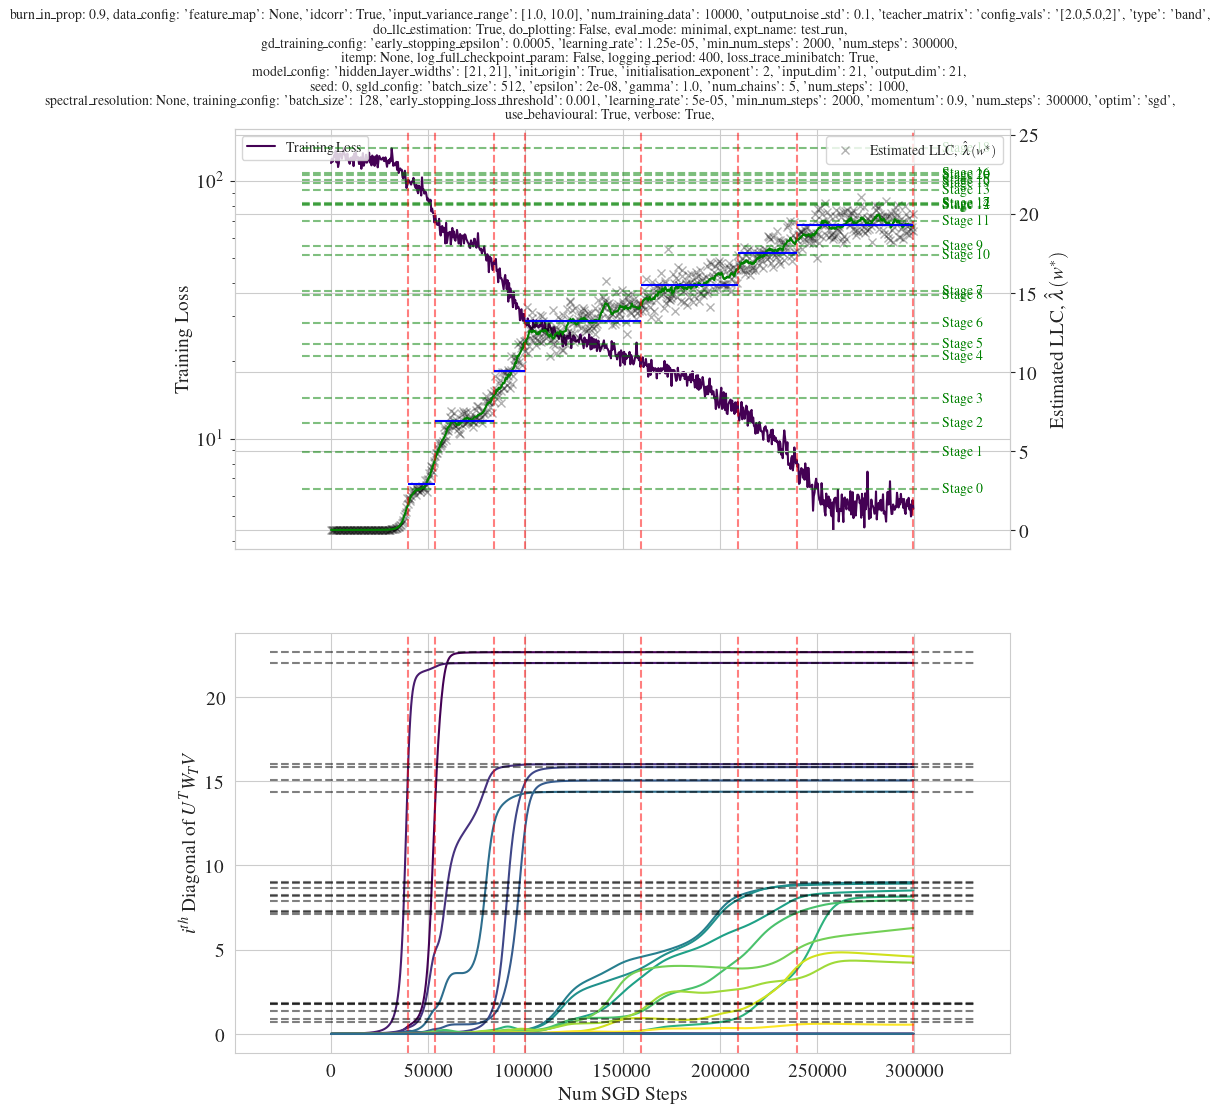

In [137]:
df = df_sgd

num_plots = 2
if eval_mode == "full":
    num_plots += 2

fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    clipped_llc = np.clip(df["lambdahat"], a_min=0, a_max=1e6)
    ax.plot(df["t"], clipped_llc, "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(clipped_llc)
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")

    CHOSEN_POTENTIAL_TYPE = "block" # "block", "row_col", "diag"
    llc_rec_block = stagewise_dfs[CHOSEN_POTENTIAL_TYPE]["other_info"]
    df_llc = pd.DataFrame.from_dict(llc_rec_block, orient="index").sort_index()
    xmin, xmax = ax.get_xlim()
    for stage in range(df_llc.shape[0]):
        llc = df_llc.loc[stage, "llc"]
        ax.hlines(llc, xmin, xmax, color="g", linestyle="--", alpha=0.5)
        ax.text(xmax, llc, f"Stage {stage}", color="g", fontsize=10, va="center")


        # llc_known_potential = df_llc.loc[stage, "llc_potential"]
        # if llc_known_potential < df_llc["llc"].max() + df_llc["llc"].mean():
        #     ax.hlines(llc_known_potential, xmin, xmax, color="r", linestyle="--", alpha=0.5)
        #     ax.text(xmax, llc_known_potential, f"Stage {stage}", color="r", fontsize=10, va="center")

    # algo = rpt.Pelt(model="l1").fit(np.array(clipped_llc.values))
    # change_points = algo.predict(pen=10)
    algo = rpt.Pelt(model="rbf").fit(np.array(clipped_llc.values))
    change_points = algo.predict(pen=5)
    for i, cp in enumerate(change_points):
        print(df.shape, cp)
        cp_prev = change_points[max(0, i - 1)]
        cp_prev_t = df["t"].iloc[cp_prev - 1]
        cp_t = df["t"].iloc[cp-1]
        mean_val = np.mean(clipped_llc[cp_prev:cp])
        ax.axvline(cp_t, color="r", linestyle="--", alpha=0.5)
        ax.hlines(mean_val, cp_prev_t, cp_t, color="b", linestyle="-", alpha=1)
else:
    change_points = None



ax = axes[1]
key = "corrected_total_matrix_diagonals"
for i in range(min(input_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")

if change_points is not None:
    for cp in change_points:
        ax.axvline(df["t"].iloc[cp-1], color="r", linestyle="--", alpha=0.5)



if eval_mode == "full":
    ax = axes[2]
    for i in range(input_output_correlation_matrix.shape[0]):
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {i})")
    ax.set_ylabel("$h_{i=j}(w_t)^2$")
    ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
    ax.legend()
    ax.set_yscale("log")

    ax = axes[3]
    for i in range(input_output_correlation_matrix.shape[0]):
        for j in range(input_output_correlation_matrix.shape[1]):
            if i == j: continue # only plot the off diagonal elements
            yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
            ax.plot(df["t"], yvals, label=f"({i}, {j})")
    ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
    ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
    ax.set_yscale("log")
    # ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


suptitle = ""
for k, v in expt_config.items():
    suptitle += f"{k}: {v}, "
    if len(suptitle.split("\n")[-1]) > 80:
        suptitle += "\n"
fig.suptitle(suptitle, fontsize=10)


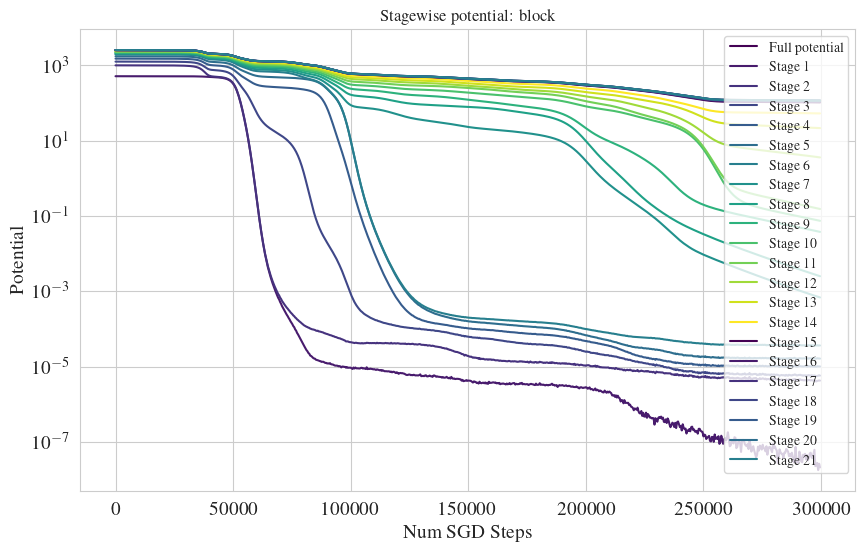

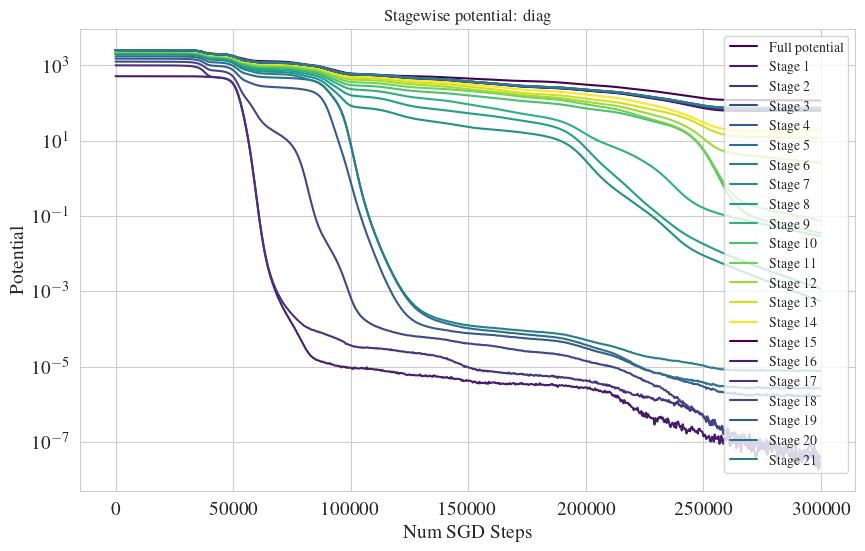

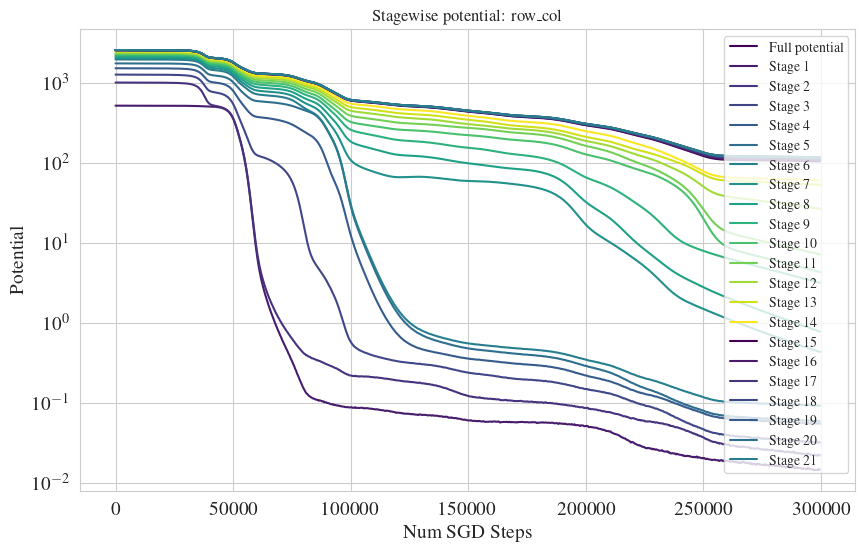

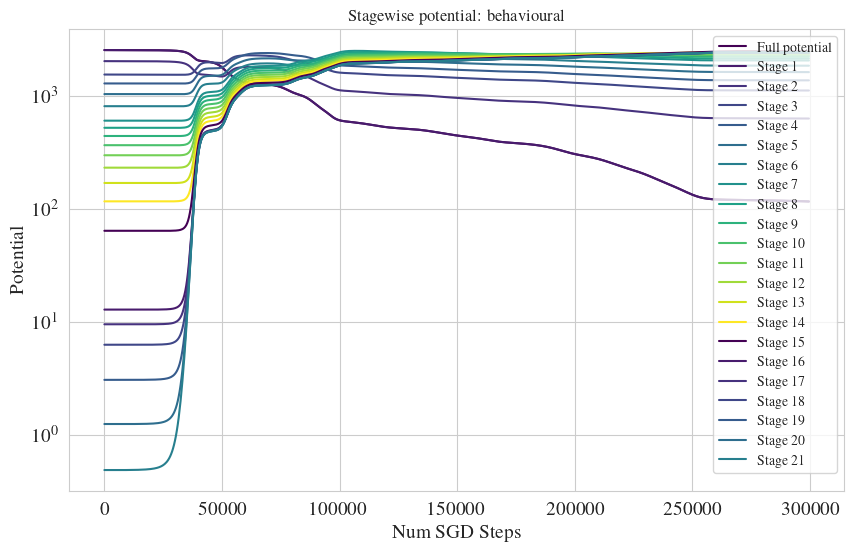

In [124]:
df = df_sgd
cols = [col for col in df.columns if col.startswith("stage_potential")]
ymin_bound = 1e-4
for col in cols:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(df["t"], df["full_potential"], label="Full potential")
    values = np.array(df[col].tolist())
    # values = np.clip(values, a_min=ymin_bound, a_max=np.inf)
    name = col.split('=')[-1]
    for stage in range(values.shape[1]):
        ax.plot(df["t"], values[:, stage], label=f"Stage {stage + 1}")
    ax.set_xlabel("Num SGD Steps")
    ax.set_ylabel("Potential")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(f"Stagewise potential: {name}")

# GD Training

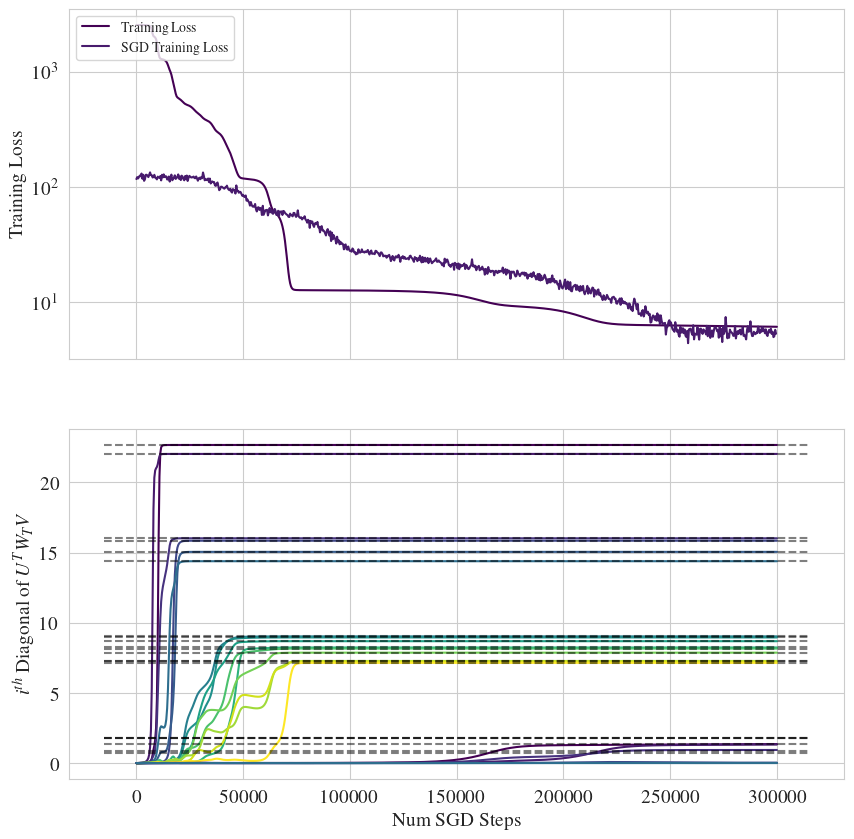

In [125]:
df = df_gd

num_plots = 2
if eval_mode == "full":
    num_plots += 2
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=True)

ax = axes[0]
ax.plot(df["t"], df["loss"], label="Training Loss")
ax.plot(df_sgd["t"], df_sgd["train_loss"], label="SGD Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

ax = axes[1]
key = "corrected_total_matrix_diagonals"
for i in range(min(input_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")


if eval_mode == "full":
    ax = axes[1]
    for i in range(input_output_correlation_matrix.shape[0]):
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {i})")
    ax.set_ylabel("$h_{i=j}(w_t)^2$")
    ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
    ax.legend()
    ax.set_yscale("log")

    ax = axes[2]
    for i in range(input_output_correlation_matrix.shape[0]):
        for j in range(input_output_correlation_matrix.shape[1]):
            if i == j: continue # only plot the off diagonal elements
            yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
            ax.plot(df["t"], yvals, label=f"({i}, {j})")
    ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
    ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
    ax.set_yscale("log")
    # ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")

# Stagewise Training

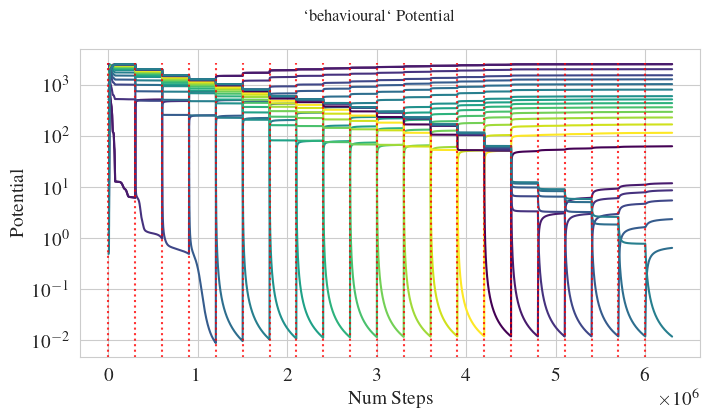

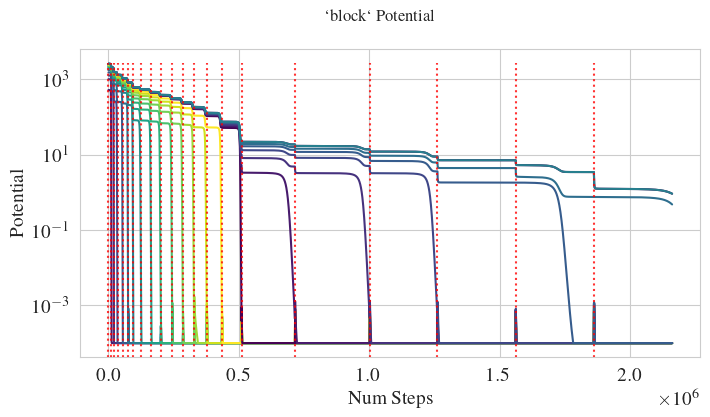

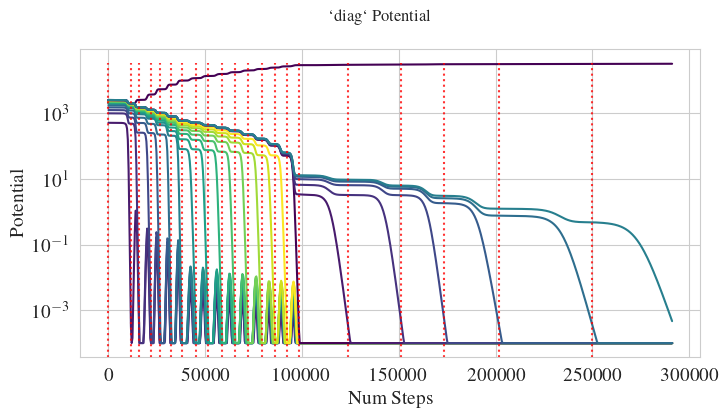

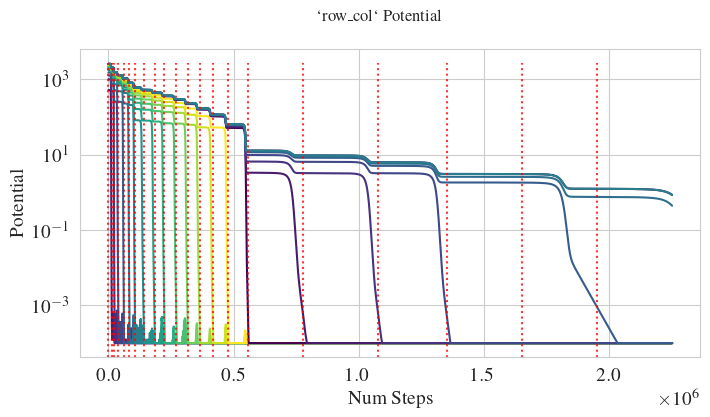

In [126]:
ymin_bound = 1e-4
# ymin_bound = -np.inf
for potential_type, rec in stagewise_dfs.items():
    df = rec["df"]
    other_info = rec["other_info"]
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    cols = ["total_potential"] + [col for col in df.columns if col.startswith("stage_potential")]
    for col in cols:
        yvals = np.clip(df[col], a_min=ymin_bound, a_max=np.inf)
        ax.plot(df["total_time"], yvals, label=col)

    stage_boundaries = df.groupby("stage")["total_time"].min().values
    ymin, ymax = ax.get_ylim()
    ax.vlines(stage_boundaries, ymin, ymax, color="r", linestyle="dotted", alpha=0.8)

    ax.set_xlabel("Num Steps")
    ax.set_ylabel("Potential")

    ax.set_yscale("log")
    # ax.set_xscale("log")
    # ax.legend()
    fig.suptitle(f"`{potential_type}` Potential")

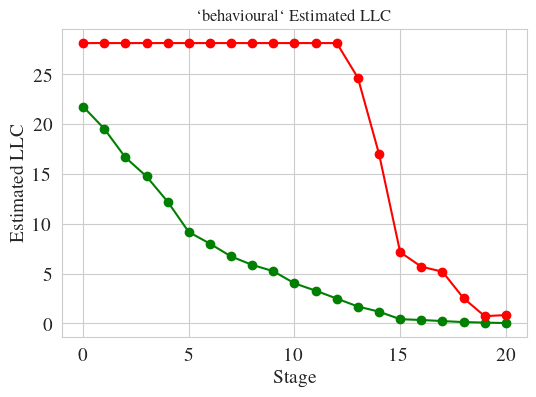

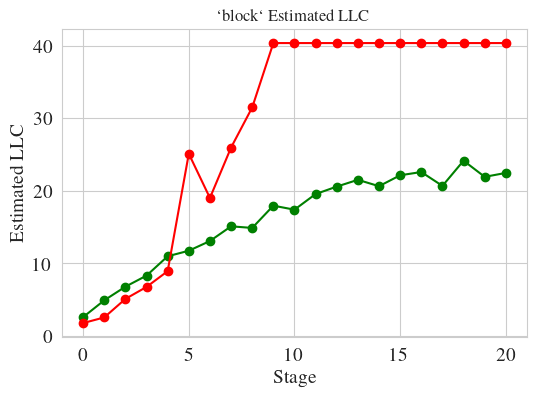

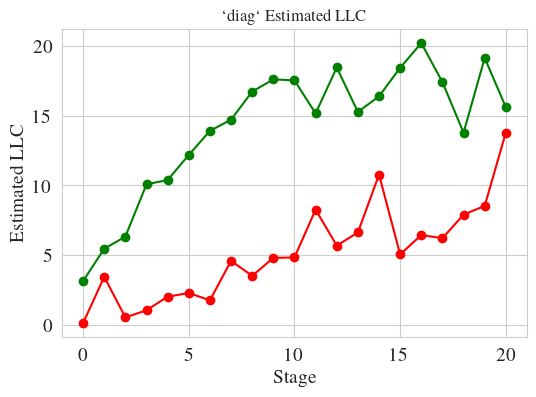

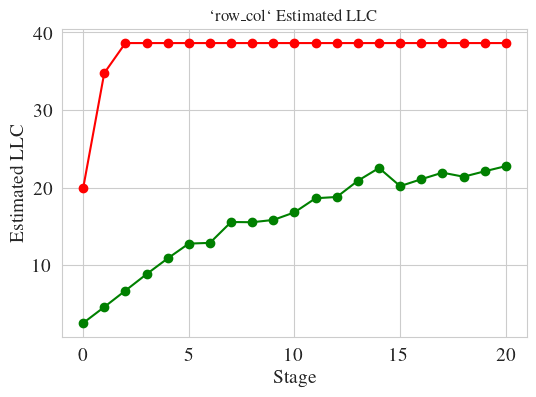

In [133]:
for potential_type, rec in stagewise_dfs.items():
    llc_rec = stagewise_dfs[potential_type]["other_info"]
    df = pd.DataFrame.from_dict(llc_rec, orient="index")
    clip_val = df["llc"].max() + df["llc"].mean()
    # clip_val = np.inf
    df = df.clip(upper=clip_val)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(df.index, df["llc"], "go-")
    ax.plot(df.index, df["llc_potential"], "ro-")
    ax.set_xlabel("Stage")
    ax.set_ylabel("Estimated LLC")
    ax.set_title(f"`{potential_type}` Estimated LLC")

Detected change points: [55, 75, 95, 110, 150, 280, 425, 750]
Detected change points: [50, 80, 95, 150, 170, 275, 425, 475, 750]


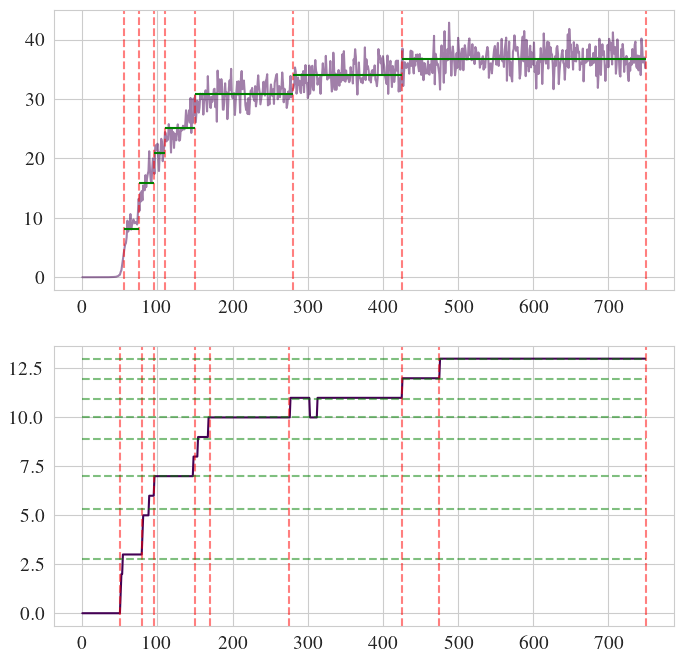

In [106]:
import ruptures as rpt

df = df_sgd
clipped_llc = df["lambdahat"].values[:]
algo = rpt.Pelt(model="rbf").fit(clipped_llc)
change_points = algo.predict(pen=5)
print(f"Detected change points: {change_points}")

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax = axes[0]
ax.plot(clipped_llc, label="Estimated LLC", alpha=0.5)
for i, cp in enumerate(change_points):
    ax.axvline(cp, color="r", linestyle="--", alpha=0.5)
    cp_prev = change_points[max(0, i - 1)]
    mean_val = np.mean(clipped_llc[cp_prev:cp])
    ax.hlines(mean_val, cp_prev, cp, color="g", linestyle="-", alpha=1)

ax = axes[1]
rs = df["corrected_total_matrix_diagonals"].map(lambda x: np.sum(np.array(x) > 4)).values
ax.plot(rs)
algo = rpt.Pelt(model="rbf").fit(rs)
change_points = algo.predict(pen=5)
print(f"Detected change points: {change_points}")
for i, cp in enumerate(change_points):
    ax.axvline(cp, color="r", linestyle="--", alpha=0.5)
    cp_prev = change_points[max(0, i - 1)]
    mean_val = np.mean(rs[cp_prev:cp])
    ax.hlines(mean_val, xmin=0, xmax=len(rs), color="g", linestyle="--", alpha=0.5)